# TW233MI - Régularisation et optimisation des modèles

## Lab 4. Regularized Logistic Regression, de A à Z

L'objectif de ce TP est d'étudier et d'implémenter une fonction de coût $L(\theta)$, associée à un modèle de régression logistique $f_{\theta}$ et de l'optimiser par l'algorithme de descente de gradient. $\theta$ dénote ici les paramètres du modèle (modèle dit paramétrique).


Nous utiliserons un jeu de données de micropuces provenant d'une usine de fabrication. Pour passer l'assurance qualité (QA), chaque micropuce passe par divers tests pour s'assurer de son bon fonctionnement. Supposons que vous êtes la/le chef.fe de produit de l'usine
et vous avez les résultats des tests pour certaines micropuces sur deux tests différents. A partir de ces deux tests $x$,
vous souhaitez déterminer si les micropuces doivent être acceptées ou non $y$. Pour vous aider à faire
la décision, vous disposez d'un ensemble de données de résultats de tests sur les micropuces passées, à partir duquel vous pouvez construire une régression logistique.

#### Implémentations à completer
- Section 3: Completer la fonction `sigmoid()`: $s(z) = \frac{1}{1+e^{-z}}$
- Section 3: Completer la fonction `predict()` en utilisant la fonction sigmoid et np.dot(x, $\theta)$=$\sum_{j=1}^d x_j \theta_j$.
- Section 4: Completer la fonction `computeCostreg()`. 
- Section 4: Completer la fonction `computeGradreg()`.
- Section 4: Completer la fonction `gradDescent()`.

### 1. Rappels de cours

Avec la régression logistique,

\begin{equation}
    p_{\theta}(x)=\mathbb{P}(y=1|x^T \theta) = sigmoid(x^T \theta) = \frac{1}{1+e^{-x^T \theta}} \in [0,1]
\end{equation}

La frontière de décision séparant les deux classes prédites est la solution de

\begin{equation}
    x^T \theta = 0
\end{equation}

La régression logistique apprend les paramètres (ou poids) $\theta_j$ afin de maximiser la vraisemblance des données, probabilité qui peut s'exprimer comme un produit de distributions de Bernoulli (hypothèse iid):

\begin{equation}
    \mathbb{P}(Y|\theta) = \Pi_{i=1}^n p_{\theta}(x_i)^{y_i}  (1-p_{\theta}(x_i))^{1-y_i} 
\end{equation}

où $p_{\theta}(x_i)$ est la probabilité prédite que $x_i$ appartienne à la première classe, $y_i$ la classe de l'instance $i$ et $n$ le nombre d'instances. Nous définissons une fonction d'erreur (ou de coût)
en prenant le logarithme négatif de la vraisemblance et en ajoutant une pénalité sur la norme du vecteur paramètres $\theta$ (et donc sur la compléxité du modèle):

\begin{equation}
    L(\theta)=-\frac{1}{n} log(\mathbb{P}(Y|\theta)) + \lambda \frac{1}{2} ||\theta||^2 = -\frac{1}{n} \sum_{i=1}^n [y_i log(p_{\theta}(x_i)) + (1-y_i) log(1-p_{\theta}(x_i))] + \frac{\lambda}{2d} \sum_{j=1}^d \theta_{j}^2
\end{equation}

Ainsi, la régression logistique cherche à trouver les paramètres $\theta$ qui minimisent la fonction de coût $L(\theta)$. Une approche itérative consiste à initialiser les paramètres $\theta$ (aléatoirement) et les apprendre (optimiser) par descente de gradient avec:

\begin{equation}
    \nabla_{\theta_j} L (\theta) = \frac{1}{n} \sum_{i=1}^n (p_{\theta}(x_i) - y_i) x_i + \frac{\lambda}{d}\theta_j
\end{equation}

Note that you should not regularize the intercept parameter $\theta_0$ (do as if $\lambda=0$ for $j=0$).

### 2. Load and inspect the data

In [1]:
# Load the dataset
import numpy as np

# Load the microchips dataset
data = np.loadtxt('data/microchips.txt', delimiter=',')

# Shuffle and split the dataset into a training and testing set.
np.random.seed(42)
np.random.shuffle(data)
n_train = int(0.8 * len(data)) # keep 80% of the dataset to train a model, test on 20%

X = data[:n_train, 0:2] # the first two columns contains the exam scores
y = data[:n_train, 2] # the third column contains the label (admitted or not)

X_test = data[n_train:, 0:2] # the first two columns contains the exam scores
y_test = data[n_train:, 2] # the third column contains the label (admitted or not)

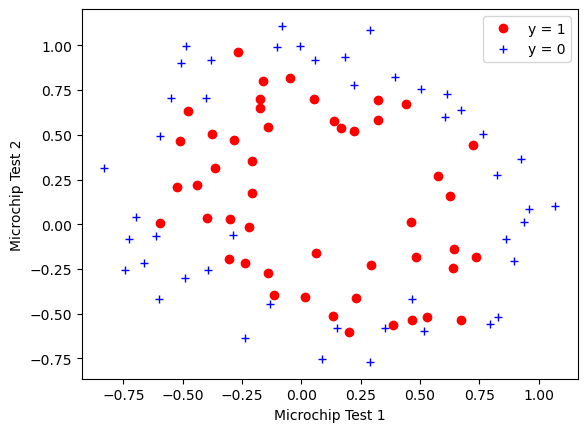

In [2]:
# Plot the training data 
import matplotlib.pyplot as plt
plt.plot(X[:,0][y == 1], X[:,1][y == 1], 'ro', label="c1")
plt.plot(X[:,0][y == 0], X[:,1][y == 0], 'b+', label="c2")
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'],numpoints=1)
plt.show()

Une application naïve de la régression logistique ne fonctionnera pas bien sur ce jeu de données, car elle ne peut modéliser qu'une frontière de décision linéaire.
Une façon de surmonter cette limitation est de construire de nouvelles caractéristiques à l'aide de polynômes,
qui transforment l'espace de départ en un espace linéairement séparable. Ci-dessous, nous fournissons un simple
exemple où les caractéristiques sont mappées dans tous les termes polynomiaux de $x_1$ et $x_2$ jusqu'au sixième degré

\begin{equation}
    F((x_1,x_2), degree=6) = [1, x_1, x_2, x_1^2, x_2^2, x_1 x_2, ..., x_2^6]
\end{equation}

Suite à cette transformation, notre vecteur de caractéristiques $(x_1,x_2)$ a été transformé en un vecteur à 28 dimensions. 
Cela nous permet de construire un classificateur plus expressif, mais également plus sensible à l'overfitting. Pour éviter le apprentissage, nous allons implémenter la régularisation L2 à la régression logistique et nous verrons comment elle peut aider.

In [3]:
def mapFeatures(X, degree = 6):
    # Generate a new feature matrix consisting of all polynomial combinations of the features
    # with degree less than or equal to the specified degree. 
    # Note: It works only for two dimensional input features.
    
    m = 1 + sum(i+1 for i in range(1,degree+1))
    n = X.shape[0]
    
    F = np.ones((n,m))

    c = 1
    for i in range(1,degree+1):
        for j in range(i+1):
            F[:,c] = (X[:,0]**(i-j))*(X[:,1]**j)
            c += 1 

    return F

In [4]:
# Generate features
# select the max degree of the polynomial features
degree = 6
X = mapFeatures(X, degree)
X_test = mapFeatures(X_test, degree)

### 3. Implement logistic regression

In [5]:
from math import e, pow

In [6]:
def sigmoid(z):
    # Computes the sigmoid of z.
    
    ### À compléter. Calculer sigmoid(z) ###
    # g = 
    ### ### ### ### ### ### ### ### ### ###
    
    return g

In [7]:
def predict(theta, X):
    # Predict whether the label is 0 or 1 using learned logistic regression parameters theta.
    # The threshold is set at 0.5
    
    n = X.shape[0] # number of training examples
    c = np.zeros(n) # predicted classes of training examples
    p = np.zeros(n) # logistic regression outputs of training examples
    
    ### À compléter. Calculer p[i] et c[i] ###
    #
    #
    #
    #
    #
    #
    ### ### ### ### ### ### ### ### ### ###
    
    return c

### 4. Optimize your model

In [8]:
def computeCostreg(theta, X, y, l, eps=0.00000001): 
    # Computes the cost of using theta as the parameter for logistic regression. 
    
    n = X.shape[0] # number of training examples
    L = 0
    
    ### À compléter. Calculer la fonction de coût L associée à theta, X et y ###
    #
    #
    ### ### ### ### ### ### ### ### ### ###
    
    return L

In [9]:
def computeGradreg(theta, X, y, l):
    # Computes the gradient of the cost with respect to the parameters.
    
    n, d = X.shape # number of training examples
    p = sigmoid(np.dot(X,theta))
    delta = p - y.reshape(-1,1)
    
    grad = np.zeros(d) # initialize gradient
    ### À compléter. Calculer le gradient de la fonction de coût par rapport à theta ###
    #
    #
    #
    ### ### ### ### ### ### ### ### ### ###    

    return (1.0 / n) *grad

#### Optimisation par descente de gradient

In [10]:
# Regularization factor
# Select the regularization parameter
ld = 1.0

We initialize parameter $\theta$ with zero and will minimize the value of the `computeCost()` function, with respect to the parameter $\theta$, using the `computeGrad()` function, that computes the gradient of the cost function. The function returns the learned values of parameter $\theta$

In [11]:
def gradDescent(X, y, ld, lr = 1.0, n_iter = 1000):
    # Returns logistic regression parameters theta, learned by gradient descent on X,y
    
    # Initialize parameters 
    theta = np.zeros((X.shape[1],1))
    print("Initial loss", computeCostreg(theta, X, y, ld))
    for k in range(n_iter):
        
        ### À compléter. Implémenter une itération de algorithme de descente de gradient ###
        #
        ### ### ### ### ### ### ### ### ### ###

    print("Final loss", computeCostreg(theta, X, y, ld))
    return theta

In [12]:
theta = gradDescent(X, y, ld, n_iter = 1000)
theta.shape

Initial loss [[0.69314718]]
Final loss [[0.52686059]]


(28, 1)

### 5. Analyser les resultats

In [13]:
def plotBoundary(X, y, degree, theta):

    #Plot Boundary
    u = np.linspace(-1,1, 100)
    v = np.linspace(-1,1, 100)
    z = np.zeros(shape=(len(u), len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            z[i, j] = sigmoid( (mapFeatures(np.array([[u[i],v[j]]]),degree)).dot(theta) )

    plt.figure(1, figsize=(10,5))
    
    plt.subplot(121)
    plt.plot(X[:,1][y == 1], X[:,2][y == 1], 'ro', label="c1")
    plt.plot(X[:,1][y == 0], X[:,2][y == 0], 'b+', label="c2")
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend(['y = 1', 'y = 0'], numpoints = 1)
    
    plt.subplot(122)
    plt.imshow(z, cmap="cool")
    plt.xlim(0,100)
    plt.ylim(0,100)
    
    plt.show()


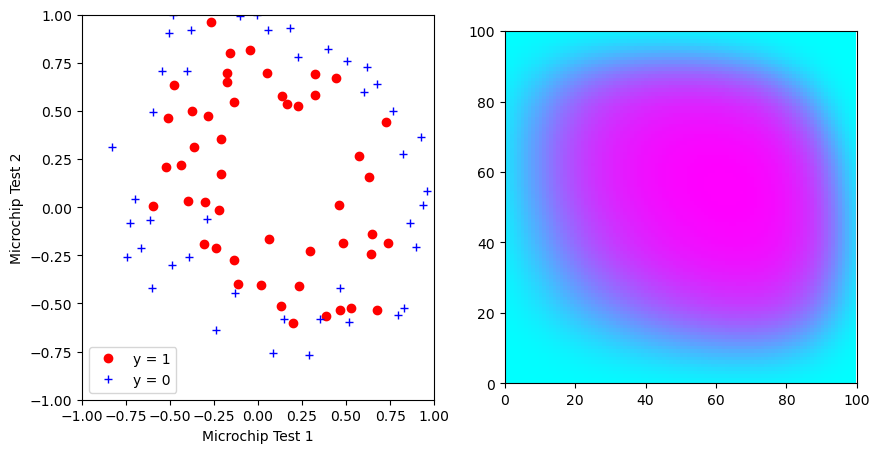

In [14]:
# Plot the decision boundary (on the training set)
plotBoundary(X, y, degree, theta)

In [15]:
# Compute accuracy (on the training set)
p = predict(np.array(theta), X)
counter = 0
for i in range(y.size):
    if p[i] == y[i]:
        counter += 1
print ('Train Accuracy: %f' % (counter / float(y.size) * 100.0))

Train Accuracy: 85.106383


In [16]:
# Compute accuracy (on the testing set)
p = predict(np.array(theta), X_test)
counter = 0
for i in range(y_test.size):
    if p[i] == y_test[i]:
        counter += 1
print ('Testing Accuracy: %f' % (counter / float(y_test.size) * 100.0))

Testing Accuracy: 75.000000


In [17]:
### À tester: Try out different regularization parameters (lambda) and polynomial degrees (degree) for the dataset 
# to understand how regularization prevents over-fitting. Notice the changes in the decision boundary as you vary
# regularize parameter, as well as the training and testing accuracy.